In [1]:
import argparse
import datetime
import numpy as np
import time
import torch
import torch.backends.cudnn as cudnn
import json
import yaml
from pathlib import Path
from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
from timm.optim import create_optimizer
from timm.utils import NativeScaler
from lib.datasets import build_dataset
from supernet_engine import train_one_epoch, evaluate
from lib.samplers import RASampler
from lib import utils
from lib.config import cfg, update_config_from_file
from model.supernet_transformer import Vision_TransformerSuper

import random, os
from timm.utils.model import unwrap_model

In [2]:
parser = argparse.ArgumentParser('Sampling archs from pretrained AutoFormer supernets', add_help=False)
parser.add_argument('--batch-size', default=256, type=int)

# custom parameters
parser.add_argument('--relative_position', type=bool, default=True)
parser.add_argument('--gp', type=bool, default=True)
parser.add_argument('--change_qkv', type=bool, default=True)
parser.add_argument('--max_relative_position', type=int, default=14, help='max distance in relative position embedding')

# AutoFormer config
parser.add_argument('--mode', type=str, default='retrain', choices=['super', 'retrain'], help='mode of AutoFormer')
parser.add_argument('--input-size', default=224, type=int)
parser.add_argument('--patch_size', default=16, type=int)

parser.add_argument('--drop', type=float, default=0.0, metavar='PCT', help='Dropout rate (default: 0.)')
parser.add_argument('--drop-path', type=float, default=0.1, metavar='PCT', help='Drop path rate (default: 0.1)')
parser.add_argument('--no_abs_pos', type=bool, default=False)

# Dataset parameters
parser.add_argument('--data-path', default='../../../dataset/ILSVRC2012/', type=str, help='dataset path')
parser.add_argument('--data-set', default='IMNET', choices=['CIFAR', 'IMNET', 'INAT', 'INAT19'],
                        type=str, help='Image Net dataset path')
parser.add_argument('--num_workers', default=16, type=int)
parser.add_argument('--pin-mem', type=bool, default=True, help='Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.')

# config file
parser.add_argument('--cfg', default='./experiments/supernet/supernet-T.yaml' ,type=str)
parser.add_argument('--resume', type=str, default='./supernet-tiny.pth', help='resume from checkpoint')
parser.add_argument('--param-limits', type=float, default=7)
parser.add_argument('--min-param-limits', type=float, default=5)
parser.add_argument('--num-archs', type=int, default=1000)
parser.add_argument('--seed', type=int, default=0)

parser.set_defaults(amp=True)

args = parser.parse_args(args=[])

device = torch.device("cuda")
update_config_from_file(args.cfg)

if args.seed is not None:
    print("The seed number is set to {}".format(args.seed))
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(args.seed)

print(args)

The seed number is set to 0
Namespace(batch_size=256, relative_position=True, gp=True, change_qkv=True, max_relative_position=14, mode='retrain', input_size=224, patch_size=16, drop=0.0, drop_path=0.1, no_abs_pos=False, data_path='../../../dataset/ILSVRC2012/', data_set='IMNET', num_workers=16, pin_mem=True, cfg='./experiments/supernet/supernet-T.yaml', resume='./supernet-tiny.pth', param_limits=7, min_param_limits=5, num_archs=1000, seed=0, amp=True)


In [3]:
# dataloader
dataset_val, args.nb_classes = build_dataset(is_train=False, args=args)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=int(2 * args.batch_size),
                                              sampler=sampler_val, num_workers=args.num_workers,
                                              pin_memory=args.pin_mem, drop_last=False)


# model
model = Vision_TransformerSuper(img_size=args.input_size,
                                patch_size=args.patch_size,
                                embed_dim=cfg.SUPERNET.EMBED_DIM, depth=cfg.SUPERNET.DEPTH,
                                num_heads=cfg.SUPERNET.NUM_HEADS,mlp_ratio=cfg.SUPERNET.MLP_RATIO,
                                qkv_bias=True, drop_rate=args.drop,
                                drop_path_rate=args.drop_path,
                                gp=args.gp,
                                num_classes=args.nb_classes,
                                max_relative_position=args.max_relative_position,
                                relative_position=args.relative_position,
                                change_qkv=args.change_qkv, abs_pos=not args.no_abs_pos)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.to(device)

choices = {'num_heads': cfg.SEARCH_SPACE.NUM_HEADS, 'mlp_ratio': cfg.SEARCH_SPACE.MLP_RATIO,
           'embed_dim': cfg.SEARCH_SPACE.EMBED_DIM , 'depth': cfg.SEARCH_SPACE.DEPTH}

In [ ]:
def sample_configs(choices):
    config = {}
    dimensions = ['mlp_ratio', 'num_heads']
    depth = random.choice(choices['depth'])
    for dimension in dimensions:
        config[dimension] = [random.choice(choices[dimension]) for _ in range(depth)]

    config['embed_dim'] = [random.choice(choices['embed_dim'])]*depth

    config['layer_num'] = depth
    return config

results = {}
results['archs'] = []
results['params'] = []
results['flops'] = []
results['acc'] = []

while len(results['archs']) < args.num_archs:

    config = sample_configs(choices=choices)
    model_module = unwrap_model(model)
    model_module.set_sample_config(config=config)
    params = model.get_sampled_params_numel(config)
    flops = model.get_complexity(model.patch_embed_super.num_patches+1)
    p = params/10**6
    if p > args.param_limits or p < args.min_param_limits:
        continue
#     print(config)
#     print(params/10**6, "M")
#     print(flops/10**9, "G")
    test_stats = evaluate(data_loader_val, model, device,  mode = args.mode, retrain_config=config)
#     print(f"Accuracy of the network on the {len(dataset_val)} test images: {test_stats['acc1']:.1f}%")    
    results['archs'].append(config)
    results['params'].append(params)
    results['flops'].append(flops)
    results['acc'].append(test_stats['acc1'])
    
    print("{} / {}".format(len(results['archs']), args.num_archs))

sampled model config: {'mlp_ratio': [4, 3.5, 3.5, 3.5, 4, 3.5, 4, 4, 3.5, 4, 3.5, 3.5, 3.5, 3.5], 'num_heads': [3, 4, 3, 3, 4, 4, 3, 4, 4, 3, 4, 3, 4, 4], 'embed_dim': [192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192], 'layer_num': 14}
sampled model parameters: 6776776
sampled model FLOPs: 1582383167.0
Test:  [ 0/98]  eta: 0:17:45  loss: 0.7376 (0.7376)  acc1: 83.3984 (83.3984)  acc5: 96.8750 (96.8750)  time: 10.8703  data: 8.8770  max mem: 1316
Test:  [10/98]  eta: 0:01:48  loss: 0.8277 (0.8098)  acc1: 83.3984 (82.4929)  acc5: 96.0938 (95.8274)  time: 1.2286  data: 0.8073  max mem: 1316
Test:  [20/98]  eta: 0:01:00  loss: 0.8826 (0.8397)  acc1: 80.4688 (81.4081)  acc5: 95.1172 (95.5729)  time: 0.2671  data: 0.0009  max mem: 1316
Test:  [30/98]  eta: 0:00:41  loss: 0.8826 (0.8550)  acc1: 80.0781 (80.5507)  acc5: 95.8984 (95.6779)  time: 0.2739  data: 0.0033  max mem: 1316
Test:  [40/98]  eta: 0:00:30  loss: 0.8540 (0.8587)  acc1: 79.1016 (80.5116)  acc5: 95.8984 (9

Test:  [ 0/98]  eta: 0:11:46  loss: 0.7244 (0.7244)  acc1: 83.3984 (83.3984)  acc5: 96.8750 (96.8750)  time: 7.2049  data: 6.9325  max mem: 1316
Test:  [10/98]  eta: 0:01:18  loss: 0.8143 (0.8015)  acc1: 83.3984 (82.2443)  acc5: 95.3125 (95.7919)  time: 0.8874  data: 0.6306  max mem: 1316
Test:  [20/98]  eta: 0:00:51  loss: 0.8833 (0.8346)  acc1: 79.2969 (81.1198)  acc5: 95.3125 (95.5729)  time: 0.3301  data: 0.0752  max mem: 1316
Test:  [30/98]  eta: 0:00:36  loss: 0.8833 (0.8506)  acc1: 78.9062 (80.3553)  acc5: 95.7031 (95.6401)  time: 0.3327  data: 0.0770  max mem: 1316
Test:  [40/98]  eta: 0:00:28  loss: 0.8569 (0.8538)  acc1: 78.9062 (80.3925)  acc5: 95.8984 (95.5554)  time: 0.3090  data: 0.0536  max mem: 1316
Test:  [50/98]  eta: 0:00:22  loss: 1.0449 (0.9411)  acc1: 73.4375 (78.2437)  acc5: 92.5781 (94.5427)  time: 0.3529  data: 0.0967  max mem: 1316
Test:  [60/98]  eta: 0:00:16  loss: 1.2145 (0.9803)  acc1: 71.2891 (77.4686)  acc5: 91.0156 (93.9837)  time: 0.3053  data: 0.0481 

In [ ]:
import pickle 

# with open('Tiny_5M-7M_1000samples.pkl', 'wb') as f:
#     pickle.dump(results, f)
        
# with open('Tiny_5M-7M_1000samples.pkl', 'rb') as f:
#     loaded_results = pickle.load(f)

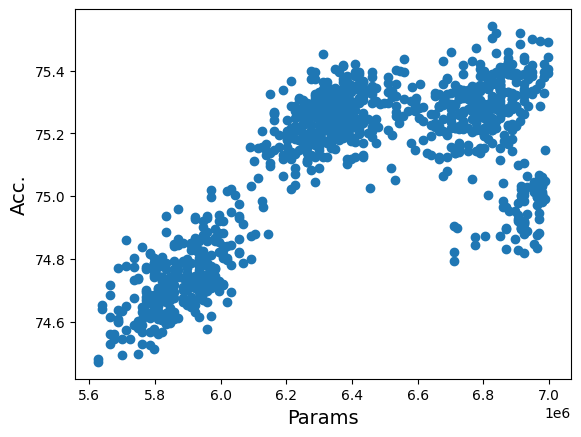

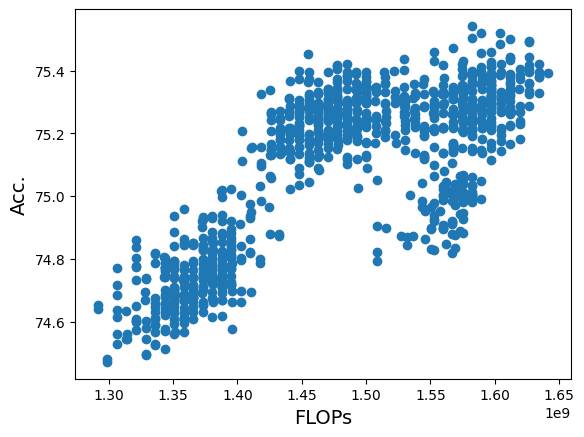

In [8]:
import matplotlib.pyplot as plt

plt.scatter(results['params'],results['acc'])
plt.ylabel('Acc.', fontsize=14)
plt.xlabel('Params', fontsize=14)
plt.show()

plt.scatter(results['flops'],results['acc'])
plt.ylabel('Acc.', fontsize=14)
plt.xlabel('FLOPs', fontsize=14)
plt.show()